In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

## classification is a problem of predicting whether something is one thing or the other(there can be multiple things at the sametime)

In [ ]:
## 1. make some data and get it ready

import sklearn
from sklearn.datasets import make_circles
# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

print(f"first 5 samples of X:\n {X[:5]}")
print(f"first 5 samples of y:\n {y[:5]}")

len(X), len(y)

first 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of y:
 [1 1 1 1 0]


(1000, 1000)

In [ ]:
# make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"x1": X[:, 0],
                        "x2": X[:, 1],
                        "label": y})
circles.head(10)


,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


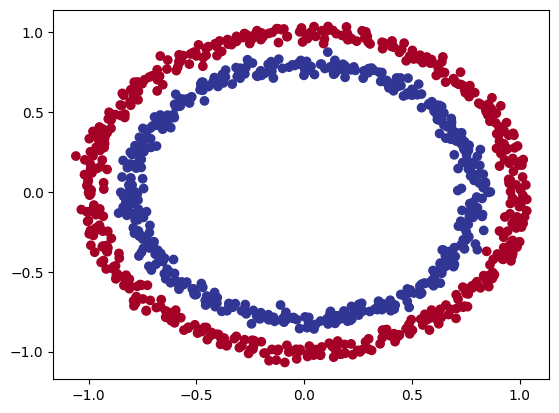

In [ ]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
x = [1, 3, 4, 5, 6, 7, 8, 9, 0, 3, 4, 5, 6, 7, 8]
print(x[10:])

[4, 5, 6, 7, 8]


In [ ]:
## The data we are working with is commonly refered to as a toy dataset

In [ ]:
x_sample = X[0]
y_sample = y[0]

print(f"values of 1 sample of X: {x_sample}, and y: {y_sample}")
print(f"shapes of 1 sample of X: {x_sample.shape}, and y: {y_sample.shape}")

values of 1 sample of X: [0.75424625 0.23148074], and y: 1
shapes of 1 sample of X: (2,), and y: ()


In [ ]:
X, y = torch.tensor(X).to(torch.float), torch.tensor(y).to(torch.float) ## represent data as tensors
X, X.shape, y, y.shape
print(f"former version of y: {y[0], y.dtype}, tensor y: {y[:5], y.dtype}")

former version of y: (tensor(1.), torch.float32), tensor y: (tensor([1., 1., 1., 1., 0.]), torch.float32)


In [ ]:
X[:5], y[:5], X.dtype, y.dtype

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]),
 torch.float32,
 torch.float32)

In [ ]:
## training : 80%, testing: 20%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# 2. Building a model
lets build a model to classify red and blue DoubleTensor

to do so we want to;
1. set up device agonistic code so our code will run on a GPU
2. construct a model by subclassing nn.Module
3. Define a loss function and optimiser
4. build a training loop

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
## constructing our model

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer2 = nn.Linear(in_features=5, out_features=1) # takes in the output of the previous layers as input and outputs a single one

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer2(self.layer1(x)) # layer 2 takes in the output of layer1
    # x -> layer1 -> layer2 -> output


model_0 = CircleModelV0().to(device)
model_0.state_dict()
next(model_0.parameters()).device



device(type='cpu')

In [ ]:
# model_0 = nn.Sequential(
#     nn.Linear(in_features=128, out_features=256),
#     nn.ReLU(),
#     nn.Linear(in_features=256, out_features=128),
#     nn.ReLU(),
#     nn.Linear(in_features=256, out_features=128),
#     nn.ReLU()
# ).to(device)
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.2484,  0.0910],
                      [ 0.2639, -0.0626],
                      [ 0.1814,  0.5379],
                      [ 0.1651, -0.6646],
                      [ 0.5944,  0.4107]])),
             ('layer1.bias',
              tensor([-0.2698, -0.5407, -0.5955,  0.1651, -0.6638])),
             ('layer2.weight',
              tensor([[-0.4394, -0.3701,  0.0015,  0.0036, -0.4026]])),
             ('layer2.bias', tensor([-0.2699]))])

In [ ]:
# make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
# y_test = y_test.unsqueeze(dim=1)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\n First 10 predictions: {torch.round(untrained_preds[:10])}, Shape: {untrained_preds.shape}")
print(f"\n First 10 labels(data we are trying to predict): {y_test[:10]}, Shape: {y_test.shape}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

 First 10 predictions: tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [1.],
        [0.]]), Shape: torch.Size([200, 1])

 First 10 labels(data we are trying to predict): tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]), Shape: torch.Size([200])


# 2.1 setup loss functions and optimiser

for this specific case we will be using BCE(binary cross entropy)with logit loss

### A Logit is a function which ensures our predictede values remain 0 and 1 as in binary

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc


# test1, test2 = torch.arange(1, 7).unsqueeze(dim=0), torch.arange(1,11).unsqueeze(dim=1)
# test1.shape, test2.shape
# accuracy_fn(test1, test2)

## Going from logits to prediction labels
our models output are going to be raw logits.
we can convert these logits into predictions probabilities by passing them some kind of activations function (e.g classification and softmax for multiclass classification)
the we can convery logits to prediction labels by either rounding them or  taking their argmax()

In [ ]:
#FLOLS
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5] ## this will yields logits

y_pred_probs = torch.sigmoid(y_logits)
y_preds = torch.round(y_pred_probs)


## Sigmoids convert logits to predicted label
since we are dealing with a binary classifications where we have with 1 or 0 as a prediction label, we want to convert our predictions logit(outputs random values) to what we can consider 50% close to the data we are making predictions on to do this we will be using the sigmoid function; what does it do?

* y_preds_probs >= 0.5, then y=1(class 1)
* y_preds_probs < 0.5, then y=0(class 0)

that is what it does, it takes a value that is really negative(can be defined in whatwever circumstance) and converts it to 0 and it takes a number leaning towards positive and classifies it as a 1.


In [ ]:
# y_pred_labels = torch.round (torch.sigmoid(model_0(X_test.to(device))[:5] ))
# print(y_preds == y_pred_labels)

In [ ]:
# 3.2 . Building a training/testing loop
torch.manual_seed(42)
epochs = 1000

# set data to device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  #F
  y_logits = model_0(X_test).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #L
  loss = loss_fn(y_logits, y_test) ## nn.BCEwithLogitsLoss expects raw logits as parameters
  acc = accuracy_fn(y_true=y_test, y_pred=y_pred)

  #O
  optimiser.zero_grad()

  #L
  loss.backward()

  #S
  optimiser.step()

  ## Testing loop
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"epoch: {epoch} \n loss: {loss:.5f} \n Acc: {acc:.2f}% \n test loss: {test_loss:.5f} \n Test acc: {test_acc: .2f}%")

epoch: 0 
 loss: 0.70781 
 Acc: 55.00% 
 test loss: 0.70763 
 Test acc:  55.00%
epoch: 10 
 loss: 0.70609 
 Acc: 56.00% 
 test loss: 0.70593 
 Test acc:  56.00%
epoch: 20 
 loss: 0.70459 
 Acc: 53.50% 
 test loss: 0.70445 
 Test acc:  53.50%
epoch: 30 
 loss: 0.70326 
 Acc: 52.50% 
 test loss: 0.70314 
 Test acc:  52.50%
epoch: 40 
 loss: 0.70210 
 Acc: 51.50% 
 test loss: 0.70199 
 Test acc:  51.50%
epoch: 50 
 loss: 0.70108 
 Acc: 51.50% 
 test loss: 0.70099 
 Test acc:  51.50%
epoch: 60 
 loss: 0.70018 
 Acc: 51.00% 
 test loss: 0.70010 
 Test acc:  51.00%
epoch: 70 
 loss: 0.69939 
 Acc: 51.00% 
 test loss: 0.69932 
 Test acc:  51.00%
epoch: 80 
 loss: 0.69869 
 Acc: 50.50% 
 test loss: 0.69863 
 Test acc:  50.50%
epoch: 90 
 loss: 0.69807 
 Acc: 51.00% 
 test loss: 0.69802 
 Test acc:  51.00%
epoch: 100 
 loss: 0.69753 
 Acc: 51.00% 
 test loss: 0.69748 
 Test acc:  50.50%
epoch: 110 
 loss: 0.69704 
 Acc: 50.00% 
 test loss: 0.69700 
 Test acc:  50.00%
epoch: 120 
 loss: 0.69661 

# visualisation, evaluate the model

from the metrics it looks like our model is not learning anything,we will now investigate

In [ ]:
import requests
from pathlib import Path

# get helper function from PyTorch
if Path("helper_functions.py").is_file():
  print("File already exists")
else:
  print("downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import plot_decision_boundary, plot_predictions


downloading helper_functions.py


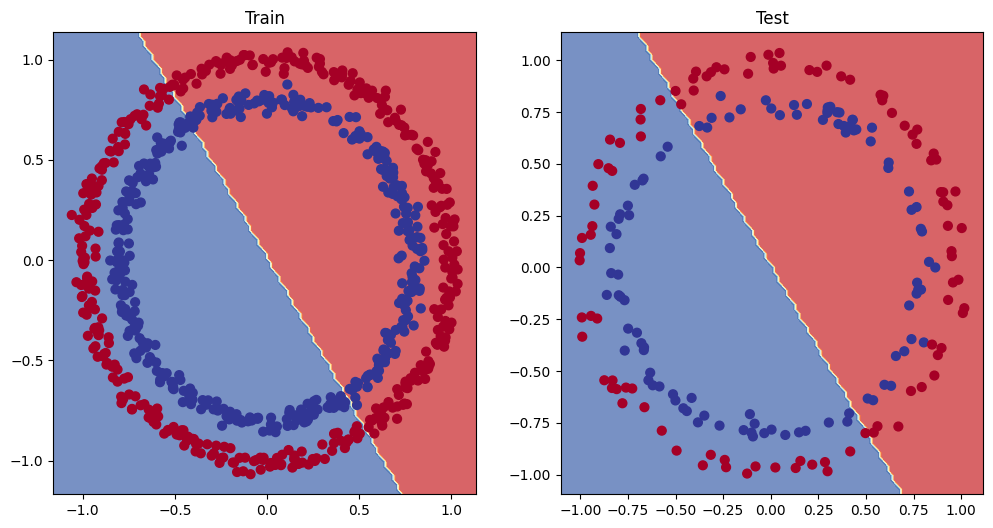

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# improve the model (from a model perspective)
* add more layers - give the model a change to learn
* add more hidden units - go from 5 to 10 hidden units
* fit for longer
* changing the activation function
* change the learning rate
* change the loss function

all of the above options are from the model's perspective, because they deal with the model and not the data, these options are refered to as **hyperparameters** since they can be changed by the ML engineers/ data scientists


In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))


model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
## create a loss function
loss_fn_v1 = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(params=model_1.parameters(), lr=0.1)

y_train.unsqueeze(dim=1)
y_train.shape

torch.Size([800])

In [ ]:
# Training and evaluations loop
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  model_1.train()
  #F
  y_logits = model_1(X_test).squeeze()
  y_pred_v1 = torch.round(torch.sigmoid(y_logits))
  #L

  loss = loss_fn_v1(y_pred_v1, y_train[:200])

  acc = accuracy_fn(y_true=y_train.unsqueeze(dim=1), y_pred=y_pred_v1)

  #O
  optimiser.zero_grad()

  #L
  loss.backward()

  #S
  optimiser.step()

  # Training
  model_1.eval()
  with torch.inference_mode():
    y_test_logits = model_1(X_test).squeeze()
    y_test_pred_v1 = torch.round(torch.sigmoid(y_test_logits))

    test_loss = loss_fn_v1(y_test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_pred_v1)

    if epoch % 10 == 0:
      print(f"epoch: {epoch} \n loss: {loss:.5f} \n Acc: {acc:.2f}% \n test loss: {test_loss:.5f} \n Test acc: {test_acc: .2f}%")
  y_pred_v1.shape, y_train.shape


epoch: 0 
 loss: 0.76541 
 Acc: 40000.00% 
 test loss: 0.69261 
 Test acc:  51.00%
epoch: 10 
 loss: 0.76541 
 Acc: 40000.00% 
 test loss: 0.69261 
 Test acc:  51.00%
epoch: 20 
 loss: 0.76541 
 Acc: 40000.00% 
 test loss: 0.69261 
 Test acc:  51.00%
epoch: 30 
 loss: 0.76541 
 Acc: 40000.00% 
 test loss: 0.69261 
 Test acc:  51.00%
epoch: 40 
 loss: 0.76541 
 Acc: 40000.00% 
 test loss: 0.69261 
 Test acc:  51.00%
epoch: 50 
 loss: 0.76541 
 Acc: 40000.00% 
 test loss: 0.69261 
 Test acc:  51.00%
epoch: 60 
 loss: 0.76541 
 Acc: 40000.00% 
 test loss: 0.69261 
 Test acc:  51.00%
epoch: 70 
 loss: 0.76541 
 Acc: 40000.00% 
 test loss: 0.69261 
 Test acc:  51.00%
epoch: 80 
 loss: 0.76541 
 Acc: 40000.00% 
 test loss: 0.69261 
 Test acc:  51.00%
epoch: 90 
 loss: 0.76541 
 Acc: 40000.00% 
 test loss: 0.69261 
 Test acc:  51.00%
epoch: 100 
 loss: 0.76541 
 Acc: 40000.00% 
 test loss: 0.69261 
 Test acc:  51.00%
epoch: 110 
 loss: 0.76541 
 Acc: 40000.00% 
 test loss: 0.69261 
 Test acc:

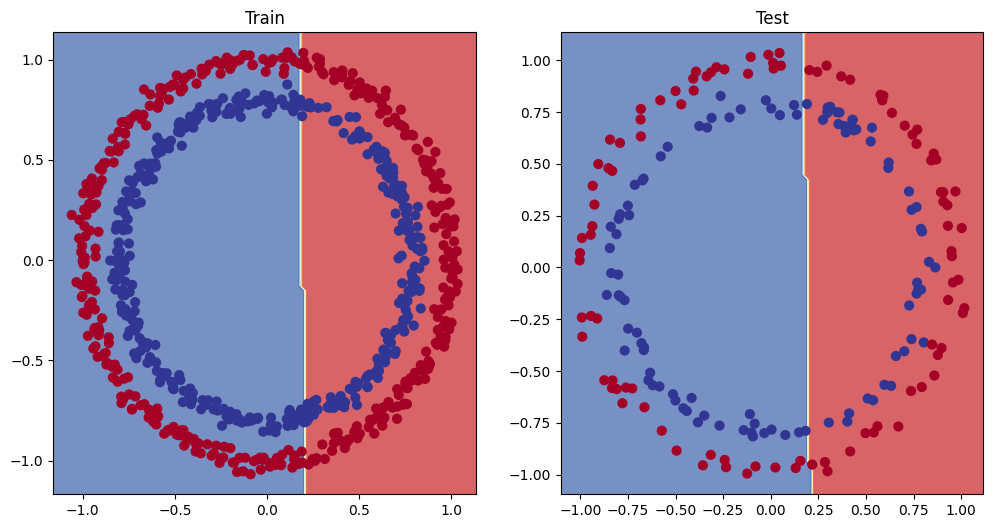

In [ ]:
## visualise for any improvments

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 5.1 Preparing data to see if our model fit a straight line

testing with a small data set can help find the problem

In [ ]:
weight, bias = 0.7, 0.3
start, end, step = 0, 1, 0.01
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
y[:10]

tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280],
        [0.3350],
        [0.3420],
        [0.3490],
        [0.3560],
        [0.3630]])

In [ ]:
train_split = int(0.8 * len(X))
X_train,y_train = X[:train_split], y[:train_split]
X_test,y_test = X[train_split:], y[train_split:]
len(X_test), len(X_train)

(20, 80)

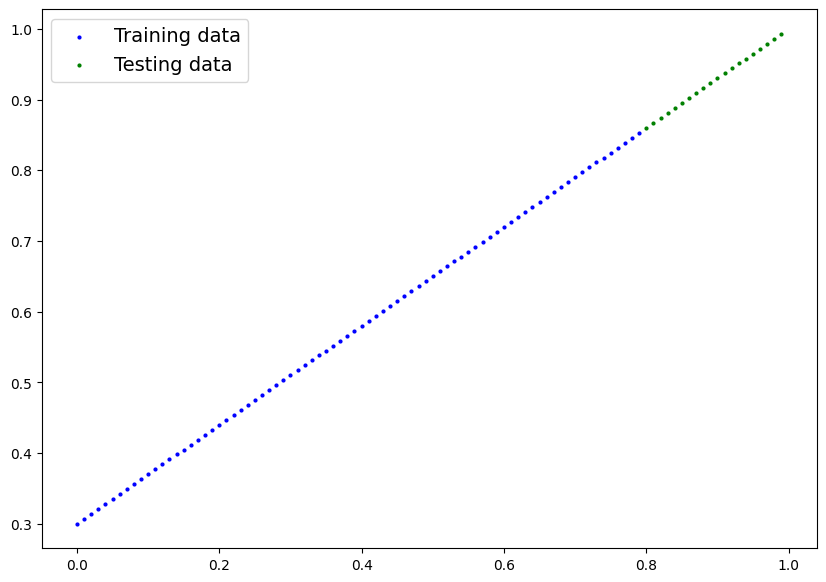

In [ ]:
plot_predictions(train_data=X_train, train_labels=y_train,
                 test_data=X_test, test_labels=y_test)

In [ ]:
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

## Adjusting model_1 to fit a Straight line

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.L1Loss()
optimiser = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [ ]:
#train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_test, y_test = X_test.to(device), y_test.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
epochs = 1000
for epoch in range(epochs):
  y_pred_2 = model_2(X_train)

  loss = loss_fn(y_pred_2, y_train)

  optimiser.zero_grad()
  loss.backward()
  optimiser.step()

  ## testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 100 == 0:
    print(f"epoch: {epoch}\n loss: {loss:.5f}\n testLoss: {test_loss:.5f}")



epoch: 0
 loss: 0.75986
 testLoss: 0.54143
epoch: 100
 loss: 0.09309
 testLoss: 0.02901
epoch: 200
 loss: 0.07376
 testLoss: 0.02850
epoch: 300
 loss: 0.06745
 testLoss: 0.00615
epoch: 400
 loss: 0.06107
 testLoss: 0.02004
epoch: 500
 loss: 0.05698
 testLoss: 0.01061
epoch: 600
 loss: 0.04857
 testLoss: 0.01326
epoch: 700
 loss: 0.06109
 testLoss: 0.02127
epoch: 800
 loss: 0.05600
 testLoss: 0.01425
epoch: 900
 loss: 0.05571
 testLoss: 0.00603


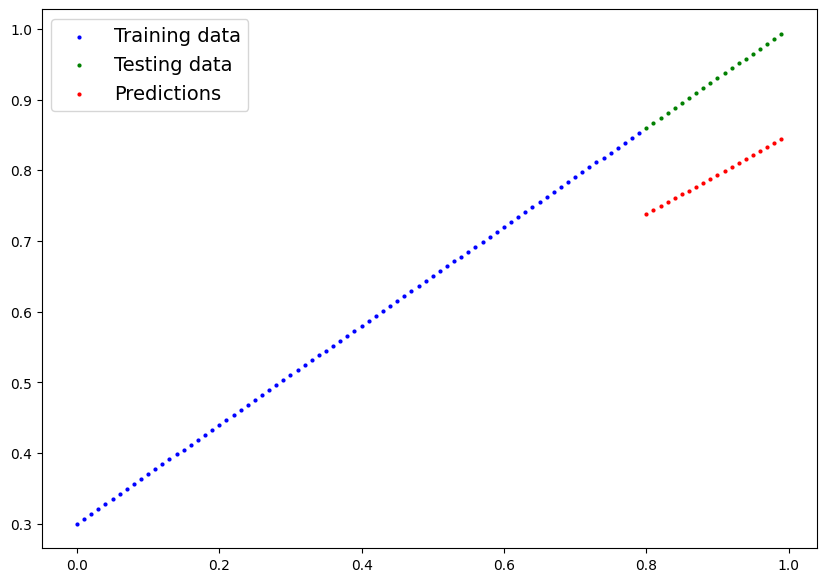

In [ ]:
# visualise
torch.manual_seed(42)
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test)

plot_predictions(train_data=X_train.cpu(), train_labels=y_train.cpu(),
                 test_data=X_test.cpu(), test_labels=y_test.cpu(), predictions=y_preds.cpu())

## 6. the missing piece is non-linearity
"what patterns could you draw if you were given a finite amount of straight and non-straight lines?"

## 6.1 recreating non-linear data(red and blue circles)

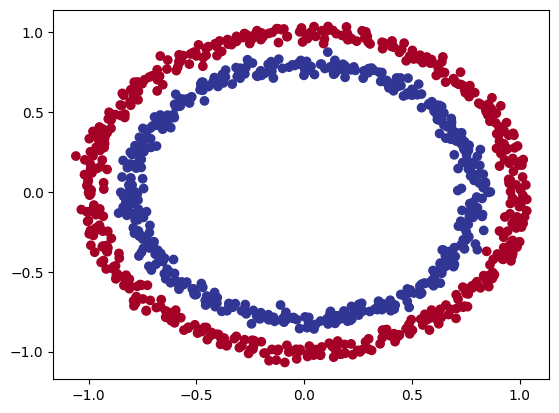

In [ ]:
# make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n = 1000
X, y = make_circles(n,
                    noise=0.03,
                    random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
from sklearn.model_selection import train_test_split
# turn data into tensor
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)


X_train[:5], y_train[:5]
type(X_train)

numpy.ndarray

In [ ]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # our NL activation function


  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# convert to tensor
X_train = torch.from_numpy(X_train).to(torch.float)
X_test = torch.from_numpy(X_test).to(torch.float)
y_train = torch.from_numpy(y_train).to(torch.float)
y_test = torch.from_numpy(y_test).to(torch.float)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(params=model_3.parameters(), lr=0.1)
torch.manual_seed(42)
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
epochs = 1000
for epoch in range(epochs):
  y_logits = model_3(X_train).squeeze()
  y_pred_labels = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred_labels)
  optimiser.zero_grad()
  loss.backward()
  optimiser.step()

  ## testing loop
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred_labels = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred_labels)
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.4f}%  | test_loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")



Epoch: 0 | Loss: 0.6929 | Acc: 50.0000%  | test_loss: 0.6932 | Test Acc: 50.0000
Epoch: 100 | Loss: 0.6912 | Acc: 52.8750%  | test_loss: 0.6910 | Test Acc: 52.5000
Epoch: 200 | Loss: 0.6898 | Acc: 53.3750%  | test_loss: 0.6894 | Test Acc: 55.0000
Epoch: 300 | Loss: 0.6879 | Acc: 53.0000%  | test_loss: 0.6872 | Test Acc: 56.0000
Epoch: 400 | Loss: 0.6852 | Acc: 52.7500%  | test_loss: 0.6841 | Test Acc: 56.5000
Epoch: 500 | Loss: 0.6810 | Acc: 52.7500%  | test_loss: 0.6794 | Test Acc: 56.5000
Epoch: 600 | Loss: 0.6751 | Acc: 54.5000%  | test_loss: 0.6729 | Test Acc: 56.0000
Epoch: 700 | Loss: 0.6666 | Acc: 58.3750%  | test_loss: 0.6632 | Test Acc: 59.0000
Epoch: 800 | Loss: 0.6516 | Acc: 64.0000%  | test_loss: 0.6476 | Test Acc: 67.5000
Epoch: 900 | Loss: 0.6236 | Acc: 74.0000%  | test_loss: 0.6215 | Test Acc: 79.0000


In [ ]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

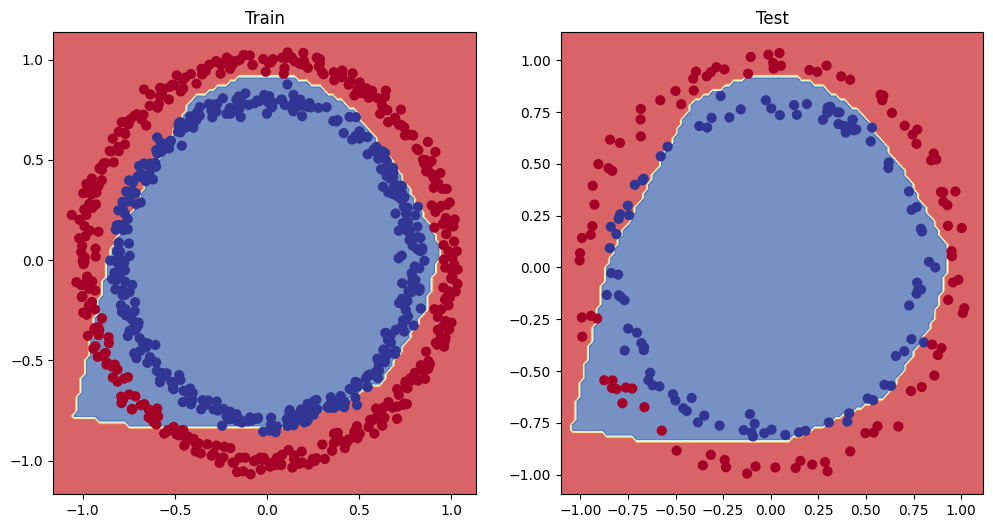

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## visualising linear and non-linear layers
we will be creating a tensor and ploting it using a linear layer and after, using ReLU(non-linear)

In [ ]:
tensor_A = torch.arange(-10, 10)
tensor_A

tensor([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
          4,   5,   6,   7,   8,   9])

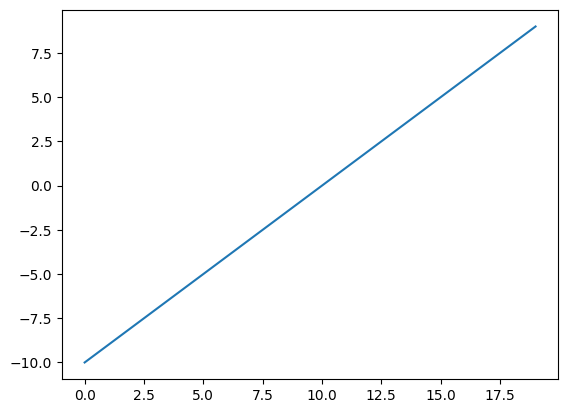

In [ ]:
plt.plot(tensor_A)

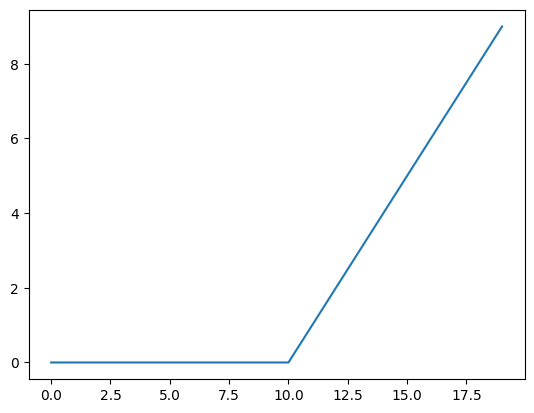

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

relu(tensor_A)
plt.plot(relu(tensor_A))

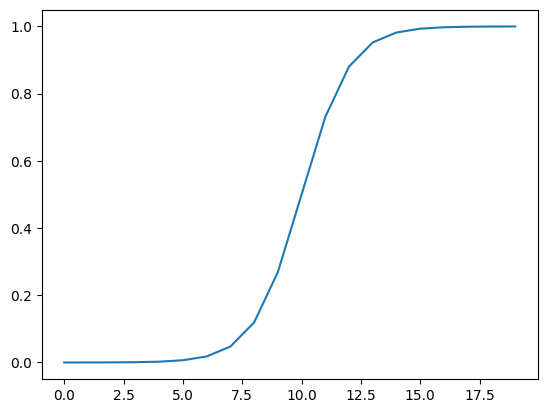

In [ ]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid(tensor_A))

## 8. Putting it all together in a multiclasss problem
compared to binary which would be, one thing or the other(1 or 0, cat or dog, fraud or not fraud), multiclass introduces more entities e.g, cat or dog, chicken

## 8.1 create a toy multi class dataset

In [ ]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

num_classes = 4
num_features = 2
RANDOM_SEED = 42
n = 1000
X_blob, y_blob = make_blobs(n_samples=n,
                            n_features=num_features,
                            centers=num_classes,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)


X_blob= torch.from_numpy(X_blob).to(torch.float)
y_blob= torch.from_numpy(y_blob).to(torch.long)



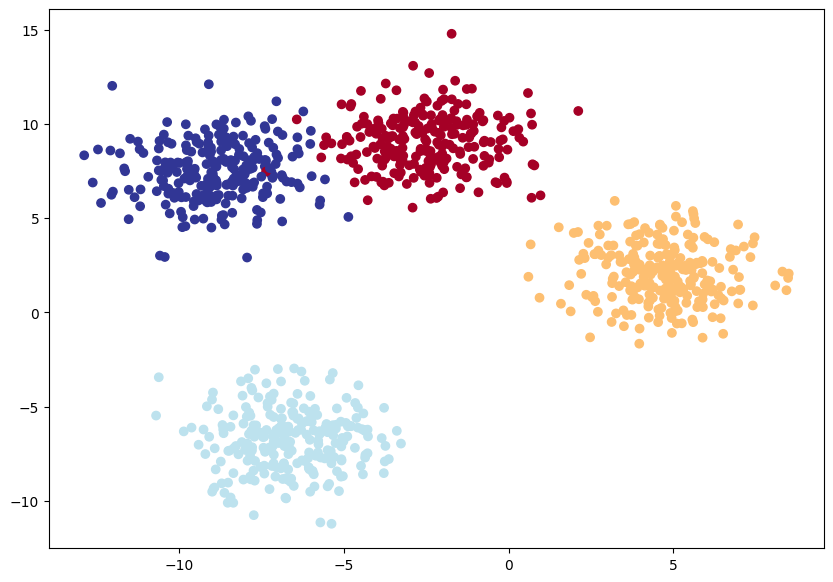

In [ ]:
## split into training and testing splits
train_split = int(0.8 * len(X_blob))

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device



'cpu'

In [ ]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    # self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_units)
    # self.layer_2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
    # self.layer_3 = nn.Linear(in_features=hidden_units, out_features=output_features)
    # self.relu = nn.ReLU()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),


    )


  def forward(self, x):
    return self.linear_layer_stack(x)


model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)



In [ ]:
next(model_4.parameters()).device

device(type='cpu')

In [ ]:
torch.unique(y_blob_train)
y_blob_train[:10], X_blob_train.shape

(tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0]), torch.Size([800, 2]))

In [ ]:
## loss function
loss_fn = nn.CrossEntropyLoss()

## optimiser
optimiser = torch.optim.SGD(params=model_4.parameters(), lr=0.1)


## getting prediction probabilities for our multi-class model PyTorch

we need to convert the logits to predictions probebilities and predictions labels

In [ ]:
## getting prediction probabilities for our multi-class model PyTorch
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

##logits
y_logits[:10]

tensor([[-0.3782, -0.0598,  0.2240,  0.1938],
        [-0.3166, -0.1224,  0.1877,  0.2034],
        [-0.3124, -0.2372,  0.2952,  0.2379],
        [-0.3386, -0.0803,  0.2329,  0.1795],
        [-0.3224, -0.0751,  0.2386,  0.1718],
        [-0.3203, -0.1184,  0.1726,  0.2133],
        [-0.3238, -0.2145,  0.2744,  0.2181],
        [-0.3122, -0.0881,  0.2237,  0.1789],
        [-0.3079, -0.2326,  0.2916,  0.2358],
        [-0.3106, -0.0812,  0.2342,  0.1718]])

In [ ]:
y_blob_test[:20]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3])

In [ ]:
# prediction probability
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]  ## this represents how much it thinks a class is accurate

tensor([[0.1674, 0.2302, 0.3057, 0.2967],
        [0.1801, 0.2187, 0.2982, 0.3029],
        [0.1771, 0.1909, 0.3251, 0.3070],
        [0.1741, 0.2254, 0.3083, 0.2923],
        [0.1763, 0.2258, 0.3089, 0.2890],
        [0.1797, 0.2199, 0.2941, 0.3063],
        [0.1769, 0.1973, 0.3217, 0.3041],
        [0.1788, 0.2237, 0.3055, 0.2921],
        [0.1779, 0.1918, 0.3239, 0.3064],
        [0.1785, 0.2245, 0.3078, 0.2892]])

In [ ]:
# predictions
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

y_logits.dtype, y_blob_train.dtype

(torch.float32, torch.int64)

In [ ]:
# training loop
torch.cuda.manual_seed(42)
torch.manual_seed(42)
epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  #F
  y_logits = model_4(X_blob_train.to(device))
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)


  #L
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  #O
  optimiser.zero_grad()
  loss.backward()
  optimiser.step()

  #testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    if epoch % 10 == 0:
      print(f"Epoch : {epoch}, loss: {loss:.4f}, acc: {acc:.2f}% , Test Loss: {test_loss:.4f}, Test Acc : {test_acc:.2f}% ")

Epoch : 0, loss: 1.3828, acc: 47.50% , Test Loss: 1.3525, Test Acc : 55.00% 
Epoch : 10, loss: 1.1864, acc: 65.12% , Test Loss: 1.1432, Test Acc : 69.50% 
Epoch : 20, loss: 0.7616, acc: 95.25% , Test Loss: 0.7508, Test Acc : 97.00% 
Epoch : 30, loss: 0.5203, acc: 97.38% , Test Loss: 0.5378, Test Acc : 98.50% 
Epoch : 40, loss: 0.4827, acc: 82.75% , Test Loss: 0.4679, Test Acc : 88.50% 
Epoch : 50, loss: 0.2696, acc: 96.75% , Test Loss: 0.2750, Test Acc : 98.50% 
Epoch : 60, loss: 0.1936, acc: 99.00% , Test Loss: 0.1908, Test Acc : 99.50% 
Epoch : 70, loss: 0.1568, acc: 99.25% , Test Loss: 0.1525, Test Acc : 99.50% 
Epoch : 80, loss: 0.1317, acc: 99.25% , Test Loss: 0.1268, Test Acc : 99.50% 
Epoch : 90, loss: 0.1127, acc: 99.25% , Test Loss: 0.1072, Test Acc : 99.50% 


In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
y_logits[:10]

tensor([[ 3.5003,  8.8986, -6.6680, -5.5565],
        [ 1.0106, -5.9475, -1.2205,  5.5540],
        [-0.6912, -0.7529,  1.7784, -0.2333],
        [ 0.7451,  5.5361, -3.0197, -3.4770],
        [ 8.8403,  4.1950, -7.8879, -3.5528],
        [ 0.8887, -6.9541, -1.4604,  6.7444],
        [-0.7026, -0.7246,  1.7347, -0.2281],
        [ 6.7197,  0.3414, -5.4694, -0.7207],
        [-0.6952, -0.7625,  1.7816, -0.2253],
        [ 7.3765,  1.6149, -6.1591, -1.6940]])

In [ ]:
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
y_pred[:10], y_blob_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]))

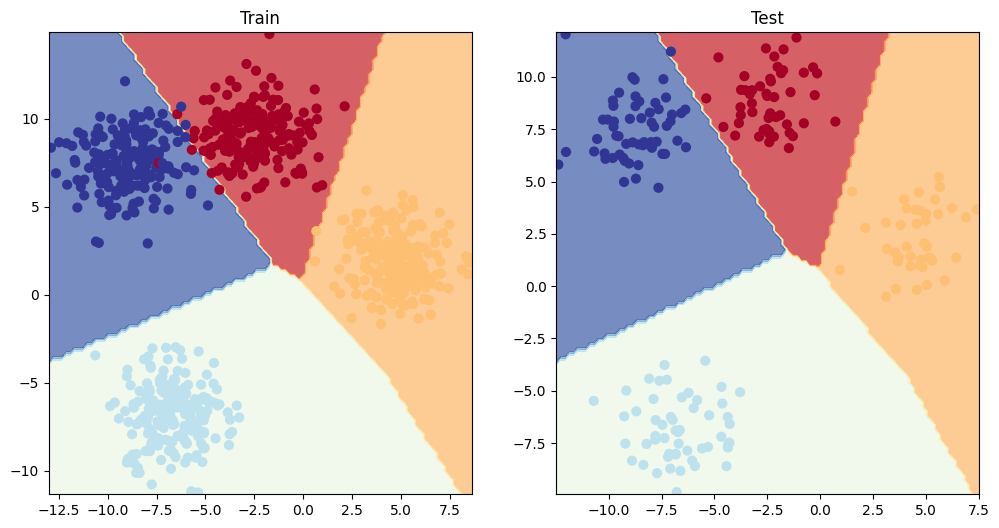

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train.to(device), y_blob_train.to(device))
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test.to(device), y_blob_test.to(device))

## 9. more classification metrics multi for evaluation
* accuracy - how accurate are pre.
* precision
* recall
* F1 -score
* confusion matrix
* classification report



In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 4.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from torchmetrics import Accuracy
torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)
torchmetric_accuracy(y_preds, y_blob_test)




tensor(0.5450)